In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import plotly.express as px
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [2]:
# import and check data
data = pd.read_csv('../input/company-bankruptcy-prediction/data.csv')
data.shape
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
#check for column names
data.columns = data.columns.str.strip()
list(data)

['Bankrupt?',
 'ROA(C) before interest and depreciation before interest',
 'ROA(A) before interest and % after tax',
 'ROA(B) before interest and depreciation after tax',
 'Operating Gross Margin',
 'Realized Sales Gross Margin',
 'Operating Profit Rate',
 'Pre-tax net Interest Rate',
 'After-tax net Interest Rate',
 'Non-industry income and expenditure/revenue',
 'Continuous interest rate (after tax)',
 'Operating Expense Rate',
 'Research and development expense rate',
 'Cash flow rate',
 'Interest-bearing debt interest rate',
 'Tax rate (A)',
 'Net Value Per Share (B)',
 'Net Value Per Share (A)',
 'Net Value Per Share (C)',
 'Persistent EPS in the Last Four Seasons',
 'Cash Flow Per Share',
 'Revenue Per Share (Yuan ¥)',
 'Operating Profit Per Share (Yuan ¥)',
 'Per Share Net profit before tax (Yuan ¥)',
 'Realized Sales Gross Profit Growth Rate',
 'Operating Profit Growth Rate',
 'After-tax Net Profit Growth Rate',
 'Regular Net Profit Growth Rate',
 'Continuous Net Profit Growth 

In [4]:
#check for missing data
data.isnull().sum().sort_values(ascending=False).head()

Bankrupt?                                                  0
ROA(C) before interest and depreciation before interest    0
Total expense/Assets                                       0
Total income/Total expense                                 0
Retained Earnings to Total Assets                          0
dtype: int64

There are no missing data

In [5]:
numeric_features = data.dtypes[data.dtypes != 'int64'].index

positive_corr = data[numeric_features].corrwith(data["Bankrupt?"]).sort_values(ascending=False)[:10].index.tolist()
negative_corr = data[numeric_features].corrwith(data["Bankrupt?"]).sort_values()[:17].index.tolist()

#check for collinearity
positive_corr.remove('Liability to Equity')
positive_corr.remove('Borrowing dependency')
positive_corr.remove('Current Liability to Assets')

negative_corr.remove('Net Value Per Share (B)')
negative_corr.remove('Net Value Per Share (C)')
negative_corr.remove('ROA(A) before interest and % after tax')
negative_corr.remove('ROA(B) before interest and depreciation after tax')
negative_corr.remove('ROA(C) before interest and depreciation before interest')
negative_corr.remove('Persistent EPS in the Last Four Seasons')
negative_corr.remove('Net profit before tax/Paid-in capital')
negative_corr.remove('Per Share Net profit before tax (Yuan ¥)')

X_num1 = data[positive_corr]
X_num2 = data[negative_corr]

#correlation matrix
X_num1.corr().style.background_gradient(cmap='coolwarm').set_precision(2)
X_num2.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

#variable selection
var = positive_corr + negative_corr + ['Bankrupt?']
data = data[var]
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


,Debt ratio %,Current Liability to Current Assets,Current Liabilities/Equity,Current Liability to Equity,Total expense/Assets,Equity to Long-term Liability,Cash/Current Liability,Net Income to Total Assets,Net worth/Assets,Retained Earnings to Total Assets,Working Capital to Total Assets,Net Income to Stockholder's Equity,Net Value Per Share (A),Working Capital/Equity,Operating Profit Per Share (Yuan ¥),Operating profit/Paid-in capital,Bankrupt?
0,0.207576,0.118250,0.339077,0.339077,0.064856,0.126549,1.473360e-04,0.716845,0.792424,0.903225,0.672775,0.827890,0.147950,0.721275,0.095921,0.095885,1
1,0.171176,0.047775,0.329740,0.329740,0.025516,0.120916,1.383910e-03,0.795297,0.828824,0.931065,0.751111,0.839969,0.182251,0.731975,0.093722,0.093743,1
2,0.207516,0.025346,0.334777,0.334777,0.021387,0.117922,5.340000e+09,0.774670,0.792484,0.909903,0.829502,0.836774,0.177911,0.742729,0.092338,0.092318,1
3,0.151465,0.067250,0.331509,0.331509,0.024161,0.120760,1.010646e-03,0.739555,0.848535,0.906902,0.725754,0.834697,0.154187,0.729825,0.077762,0.077727,1
4,0.106509,0.047725,0.330726,0.330726,0.026385,0.110933,6.804636e-04,0.795016,0.893491,0.913850,0.751822,0.839973,0.167502,0.732000,0.096898,0.096927,1


For the model assumptions, we want to ensure that our data are independent and equally distributed. One way to do this is to have the uncorrelated variables choose to eliminate collinearity. We select highly correlated variables (both positive and negative) as 'Bankrupt?'. However, make sure they are not highly correlated with each other.

Counter({1: 220, 0: 6599})

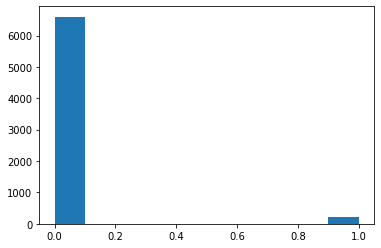

In [6]:
plt.hist(data["Bankrupt?"])
from collections import Counter
Counter(data["Bankrupt?"])

Counter({1: 220, 0: 220})

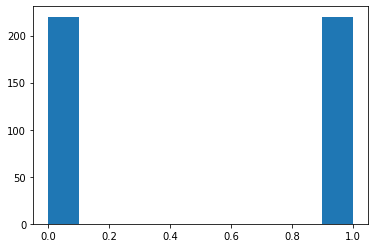

In [7]:
#split data for 80% training and 20% validation set

#adjust for over/undersampling

#shuffle the Dataset.
shuffled_df = data.sample(frac=1,random_state=4)

#put all the fraud class in a separate dataset.
y_1 = shuffled_df.loc[shuffled_df['Bankrupt?'] == 1]

#randomly select 492 observations from the non-fraud (majority class)
y_0 = shuffled_df.loc[shuffled_df['Bankrupt?'] == 0].sample(n=220,random_state=42)

#concatenate both dataframes again
normalized_df = pd.concat([y_1, y_0])
X = normalized_df.drop('Bankrupt?', axis=1)
y = normalized_df['Bankrupt?']
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

#check and show new data
plt.hist(normalized_df["Bankrupt?"])
from collections import Counter
Counter(normalized_df["Bankrupt?"])

In [8]:
results = pd.DataFrame(columns = ['Model', 'TPR', 'FPR', 'precision', 'recall', 'accuracy', 'f1-score'])
results.head()

,Model,TPR,FPR,precision,recall,accuracy,f1-score


In [9]:
#SVM
from sklearn.metrics import f1_score

#create model
model1 = SVC(probability=True, C=1, kernel='rbf')
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(x_train, y_train)
model1 = model1.fit(Xsm_train, ysm_train)
prediction = model1.predict(x_test)
print(classification_report(y_test, prediction))

cnf_matrix = confusion_matrix(y_test, model1.predict(x_test))
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

#sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
#specificity or true negative rate
TNR = TN/(TN+FP) 
#precision or positive predictive value
PPV = TP/(TP+FP)
#negative predictive value
NPV = TN/(TN+FN)
#fall out or false positive rate
FPR = FP/(FP+TN)
#false negative rate
FNR = FN/(TP+FN)
#false discovery rate
FDR = FP/(TP+FP)
#overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#eval
Model = 'SVM' 
TPR = [round(num, 2) for num in TPR]
FPR = [round(num, 2) for num in FPR]
precision = [round(num, 2) for num in PPV]
recall = [round(num, 2) for num in TPR]
accuracy = [round(num, 2) for num in ACC]
f1_score = round(f1_score(y_test, prediction),2)
row = [Model, TPR, FPR, precision, recall, accuracy, f1_score]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

              precision    recall  f1-score   support

           0       0.52      1.00      0.68        44
           1       1.00      0.07      0.13        44

    accuracy                           0.53        88
   macro avg       0.76      0.53      0.40        88
weighted avg       0.76      0.53      0.40        88



,Model,TPR,FPR,precision,recall,accuracy,f1-score
0,SVM,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13


In [10]:
#logistic Regression
from sklearn.metrics import f1_score

#create model
model2 = LogisticRegression(C=1.0, penalty='l2', solver='newton-cg')
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(x_train, y_train)
model2 = model2.fit(Xsm_train, ysm_train)
prediction = model2.predict(x_test)
print(classification_report(y_test, prediction))

cnf_matrix = confusion_matrix(y_test, model2.predict(x_test))
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

#sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
#specificity or true negative rate
TNR = TN/(TN+FP) 
#precision or positive predictive value
PPV = TP/(TP+FP)
#negative predictive value
NPV = TN/(TN+FN)
#fall out or false positive rate
FPR = FP/(FP+TN)
#false negative rate
FNR = FN/(TP+FN)
#false discovery rate
FDR = FP/(TP+FP)
#overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#eval
Model = 'logistic regression'
TPR = [round(num, 2) for num in TPR]
FPR = [round(num, 2) for num in FPR]
precision = [round(num, 2) for num in PPV]
recall = [round(num, 2) for num in TPR]
accuracy = [round(num, 2) for num in ACC]
f1_score = round(f1_score(y_test, prediction),2)
row = [Model, TPR, FPR, precision, recall, accuracy, f1_score]
results = results.append(pd.DataFrame([row], columns=results.columns), ignore_index=True)
results

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        44
           1       0.89      0.89      0.89        44

    accuracy                           0.89        88
   macro avg       0.89      0.89      0.89        88
weighted avg       0.89      0.89      0.89        88



,Model,TPR,FPR,precision,recall,accuracy,f1-score
0,SVM,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13
1,logistic regression,"[0.89, 0.89]","[0.11, 0.11]","[0.89, 0.89]","[0.89, 0.89]","[0.89, 0.89]",0.89


In [11]:
#Naive Bayes
from sklearn.metrics import f1_score
model3 = GaussianNB(var_smoothing=1.0)
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(x_train, y_train)
model3 = model3.fit(Xsm_train, ysm_train)
prediction = model3.predict(x_test)
print(classification_report(y_test, prediction))

cnf_matrix = confusion_matrix(y_test, model3.predict(x_test))
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

#sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
#specificity or true negative rate
TNR = TN/(TN+FP) 
#precision or positive predictive value
PPV = TP/(TP+FP)
#negative predictive value
NPV = TN/(TN+FN)
#fall out or false positive rate
FPR = FP/(FP+TN)
#false negative rate
FNR = FN/(TP+FN)
#false discovery rate
FDR = FP/(TP+FP)
#overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#eval
Model = 'naive bayes'
TPR = [round(num, 2) for num in TPR]
FPR = [round(num, 2) for num in FPR]
precision = [round(num, 2) for num in PPV]
recall = [round(num, 2) for num in TPR]
accuracy = [round(num, 2) for num in ACC]
f1_score = round(f1_score(y_test, prediction),2)
row3 = [Model, TPR, FPR, precision, recall, accuracy, f1_score]
results = results.append(pd.DataFrame([row3], columns=results.columns), ignore_index=True)
results

              precision    recall  f1-score   support

           0       0.52      1.00      0.68        44
           1       1.00      0.07      0.13        44

    accuracy                           0.53        88
   macro avg       0.76      0.53      0.40        88
weighted avg       0.76      0.53      0.40        88



,Model,TPR,FPR,precision,recall,accuracy,f1-score
0,SVM,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13
1,logistic regression,"[0.89, 0.89]","[0.11, 0.11]","[0.89, 0.89]","[0.89, 0.89]","[0.89, 0.89]",0.89
2,naive bayes,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13


F1 score analysis: 
Logistic Regression based on the 3 models generated is much better than SVM and naive Bayes. The highest value is 1 and the lowest value is 0, indicating that there is room for improvement in balancing precision and recall. When this analysis was first run, the SMOTE function was not used, resulting in biased data and lower F1 scores. Running it again with the SMOTE function produces a higher F1 value. Let's examine the precision and recall curves to see where the model can be improved.

In [12]:
#Build ROC + Precision / Recall Graphs

#SVM
y_score = model1.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [13]:
#logistic Regression
y_score = model2.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [14]:
#Naive Bayes
#SVM
y_score = model3.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

Precision-recall curve analysis: 
For all SVM and naive Bayes graphs, the precision-recall curve indicates that there is a high degree of precision that offsets the very low recall. And vice versa, there are high paybacks with low precision trading. It's not well balanced, and perhaps adjusting the model using a different scoring method will improve the precision-recall graph. On the other hand, logistic regression does a great job with high precision and accuracy without having to compromise either too much. Logistic regression models do the best in terms of accuracy and precision in predicting whether the data will go bankrupt with an f-score of 0.89.

In [15]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

In [16]:
#Random Forest Classifier
from sklearn.metrics import f1_score

#create model
model4 = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=5, max_features='auto', max_depth=None, criterion='entropy', bootstrap=False)
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(x_train, y_train)
model4 = model4.fit(Xsm_train, ysm_train)
prediction = model4.predict(x_test)
print(classification_report(y_test, prediction))

cnf_matrix = confusion_matrix(y_test, model4.predict(x_test))
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#eval
Model = 'Random Forest Classifier' 
TPR = [round(num, 2) for num in TPR]
FPR = [round(num, 2) for num in FPR]
precision = [round(num, 2) for num in PPV]
recall = [round(num, 2) for num in TPR]
accuracy = [round(num, 2) for num in ACC]
f1_score = round(f1_score(y_test, prediction),2)
row4 = [Model, TPR, FPR, precision, recall, accuracy, f1_score]
results = results.append(pd.DataFrame([row4], columns=results.columns), ignore_index=True)
results

              precision    recall  f1-score   support

           0       0.95      0.86      0.90        44
           1       0.88      0.95      0.91        44

    accuracy                           0.91        88
   macro avg       0.91      0.91      0.91        88
weighted avg       0.91      0.91      0.91        88



,Model,TPR,FPR,precision,recall,accuracy,f1-score
0,SVM,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13
1,logistic regression,"[0.89, 0.89]","[0.11, 0.11]","[0.89, 0.89]","[0.89, 0.89]","[0.89, 0.89]",0.89
2,naive bayes,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13
3,Random Forest Classifier,"[0.86, 0.95]","[0.05, 0.14]","[0.95, 0.88]","[0.86, 0.95]","[0.91, 0.91]",0.91


In [17]:
#Gradient Boosted Trees
from sklearn.metrics import f1_score

#create model
model5 = GradientBoostingClassifier()
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(x_train, y_train)
model5 = model5.fit(Xsm_train, ysm_train)
prediction = model5.predict(x_test)
print(classification_report(y_test, prediction))

cnf_matrix = confusion_matrix(y_test, model5.predict(x_test))
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#eval
Model = 'Gradient Boosted Trees' 
TPR = [round(num, 2) for num in TPR]
FPR = [round(num, 2) for num in FPR]
precision = [round(num, 2) for num in PPV]
recall = [round(num, 2) for num in TPR]
accuracy = [round(num, 2) for num in ACC]
f1_score = round(f1_score(y_test, prediction),2)
row5 = [Model, TPR, FPR, precision, recall, accuracy, f1_score]
results = results.append(pd.DataFrame([row5], columns=results.columns), ignore_index=True)
results

              precision    recall  f1-score   support

           0       0.93      0.84      0.88        44
           1       0.85      0.93      0.89        44

    accuracy                           0.89        88
   macro avg       0.89      0.89      0.89        88
weighted avg       0.89      0.89      0.89        88



,Model,TPR,FPR,precision,recall,accuracy,f1-score
0,SVM,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13
1,logistic regression,"[0.89, 0.89]","[0.11, 0.11]","[0.89, 0.89]","[0.89, 0.89]","[0.89, 0.89]",0.89
2,naive bayes,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13
3,Random Forest Classifier,"[0.86, 0.95]","[0.05, 0.14]","[0.95, 0.88]","[0.86, 0.95]","[0.91, 0.91]",0.91
4,Gradient Boosted Trees,"[0.84, 0.93]","[0.07, 0.16]","[0.92, 0.85]","[0.84, 0.93]","[0.89, 0.89]",0.89


In [18]:
#Extra Trees
from sklearn.metrics import f1_score

#create model
model6 = ExtraTreesClassifier()
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(x_train, y_train)
model6 = model6.fit(Xsm_train, ysm_train)
prediction = model6.predict(x_test)
print(classification_report(y_test, prediction))

#======================================================================
cnf_matrix = confusion_matrix(y_test, model6.predict(x_test))
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#eval
Model = 'Extra Trees' 
TPR = [round(num, 2) for num in TPR]
FPR = [round(num, 2) for num in FPR]
precision = [round(num, 2) for num in PPV]
recall = [round(num, 2) for num in TPR]
accuracy = [round(num, 2) for num in ACC]
f1_score = round(f1_score(y_test, prediction),2)
row6 = [Model, TPR, FPR, precision, recall, accuracy, f1_score]
results = results.append(pd.DataFrame([row6], columns=results.columns), ignore_index=True)
results

              precision    recall  f1-score   support

           0       0.95      0.84      0.89        44
           1       0.86      0.95      0.90        44

    accuracy                           0.90        88
   macro avg       0.90      0.90      0.90        88
weighted avg       0.90      0.90      0.90        88



,Model,TPR,FPR,precision,recall,accuracy,f1-score
0,SVM,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13
1,logistic regression,"[0.89, 0.89]","[0.11, 0.11]","[0.89, 0.89]","[0.89, 0.89]","[0.89, 0.89]",0.89
2,naive bayes,"[1.0, 0.07]","[0.93, 0.0]","[0.52, 1.0]","[1.0, 0.07]","[0.53, 0.53]",0.13
3,Random Forest Classifier,"[0.86, 0.95]","[0.05, 0.14]","[0.95, 0.88]","[0.86, 0.95]","[0.91, 0.91]",0.91
4,Gradient Boosted Trees,"[0.84, 0.93]","[0.07, 0.16]","[0.92, 0.85]","[0.84, 0.93]","[0.89, 0.89]",0.89
5,Extra Trees,"[0.84, 0.95]","[0.05, 0.16]","[0.95, 0.86]","[0.84, 0.95]","[0.9, 0.9]",0.90


Let's check the three models we added this time: Random Forest Classifier, Gradient Boosted Trees, and Extra Trees.
It can be seen that 
True Positive Rate = 0.84 < TPR < 0.95 is still in the high range.
False Positive Rate = 0.05 < FPR < 0.16 It can be seen that it is still in the low range.

Of the models checked last week, only the Logistic Regression model showed 0.91 in F-1 score, but all three models checked this week showed F-1 scores of 0.89 and 0.91, respectively, so precision, recall, and accuracy are all well balanced. And it shows a lot of improvement compared to last week. This week's addition of three models yields excellent predictors for predicting bankruptcy.

In [19]:
#Random Forest Classifier
y_score = model4.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

#=====================================

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [20]:
#Gradient Boosted Trees
y_score = model5.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

#=====================================

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()

In [21]:
#Extra Trees
y_score = model6.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

#=====================================

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

fig = px.area(
    x=recall, y=precision,
    title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='Recall', y='Precision'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=1, y1=0
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.show()